<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, pandas as pd
import pcmdpy as ppy
%matplotlib inline

GPU acceleration enabled


In [2]:
try:
    ppy.gpu_utils.initialize_gpu(n=0)
    __GPU_AVAIL = True
except:
    __GPU_AVAIL = False

using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [3]:
f_base = ppy.instrument.default_m51_filters()
f_low = ppy.instrument.default_m51_filters()
for f in f_low:
    f._exposure /= 4.

In [4]:
results = {}
results['base'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_tau.csv',
                                              run_name='Baseline')

In [5]:
results['log'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_log_tau.csv',
                                             run_name='LogHess')
results['quarter'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_quarter_tau.csv',
                                                run_name='QuarterExp')
results['quarter_log'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_quarter_log_tau.csv',
                                                    run_name='Quarter + Log')

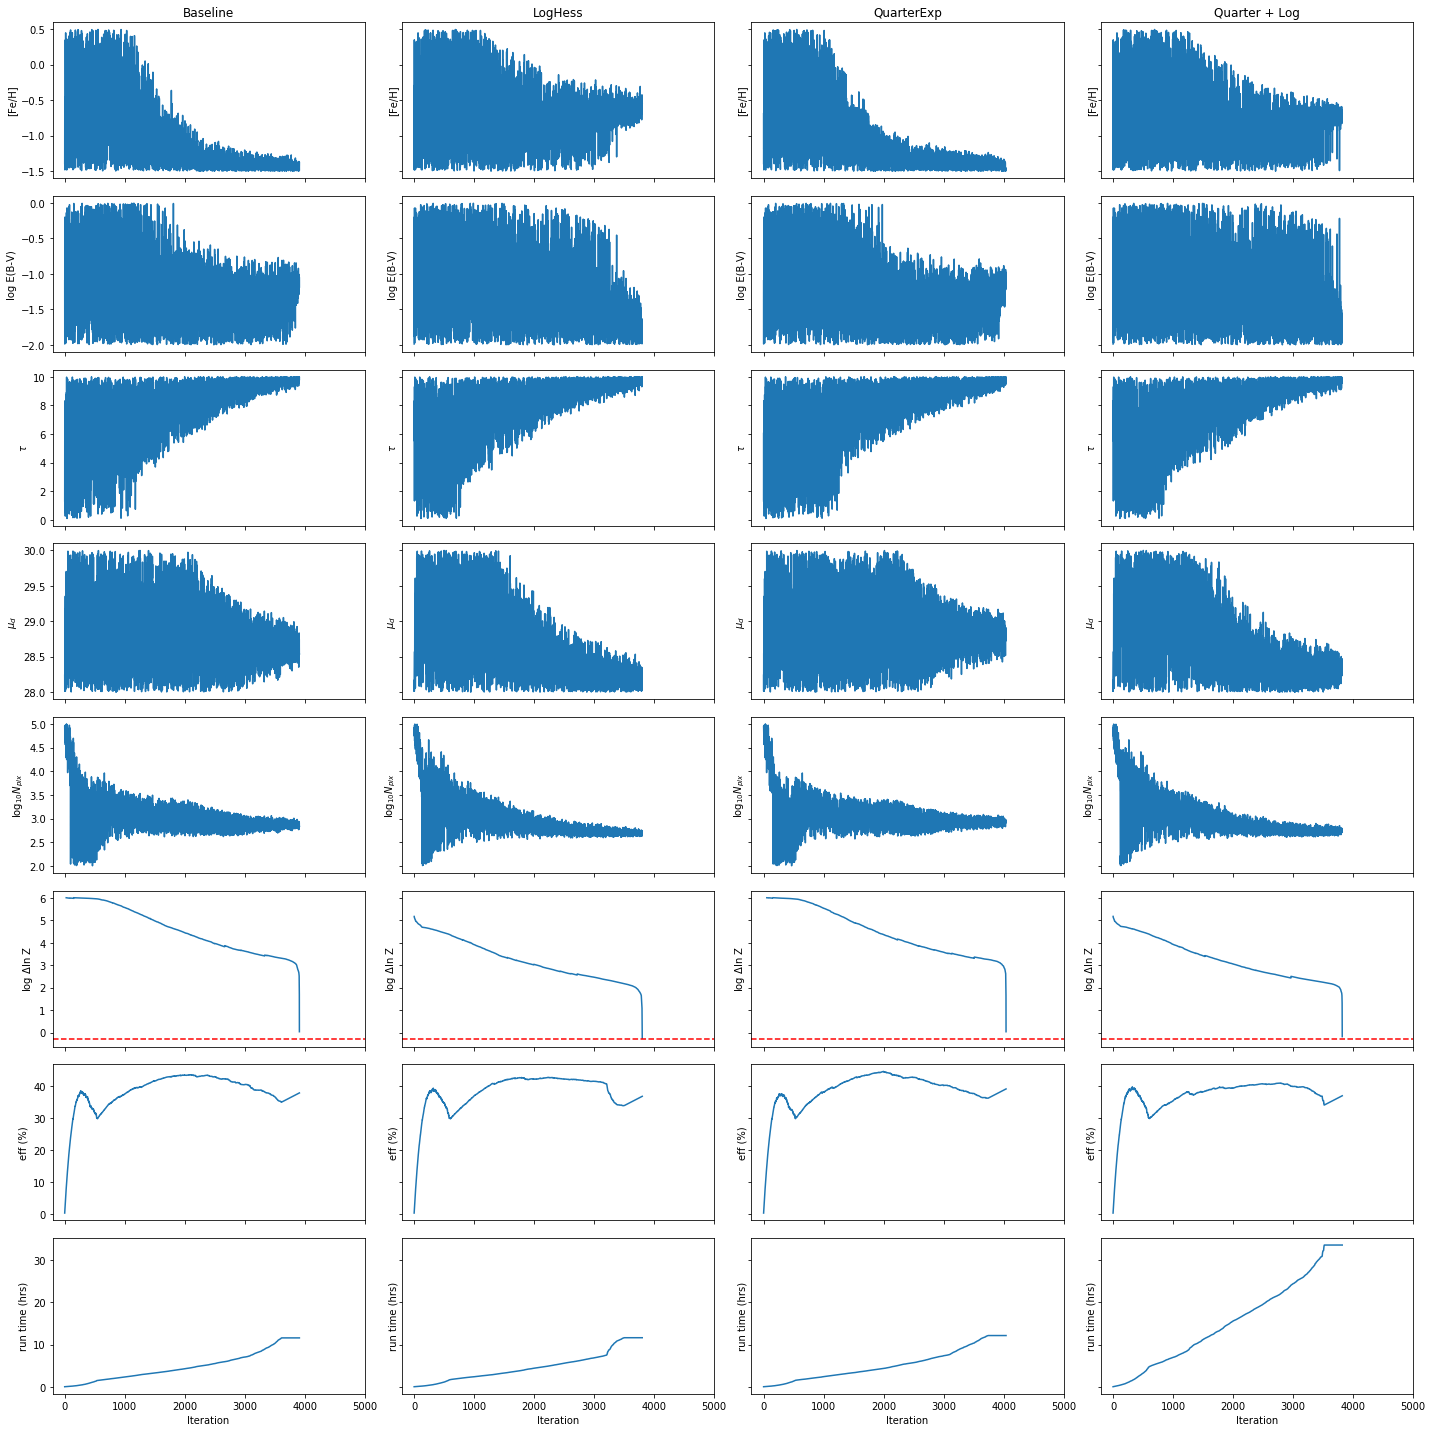

In [6]:
fig, axes = plt.subplots(ncols=4, nrows=8, sharey='row', sharex=True, figsize=(20, 20))
results['base'].plot_chains(axes=axes[:,0]);
results['log'].plot_chains(axes=axes[:,1]);
results['quarter'].plot_chains(axes=axes[:,2]);
results['quarter_log'].plot_chains(axes=axes[:,3]);
axes[0,0].set_xlim(xmax=5000)
plt.tight_layout()

In [7]:
results['base'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_nonparam.csv',
                                              run_name='Baseline')
results['log'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_log_nonparam.csv',
                                             run_name='LogHess')
results['quarter'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_quarter_nonparam.csv',
                                                run_name='QuarterExp')
results['quarter_log'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_quarter_log_nonparam.csv',
                                                    run_name='Quarter + Log')

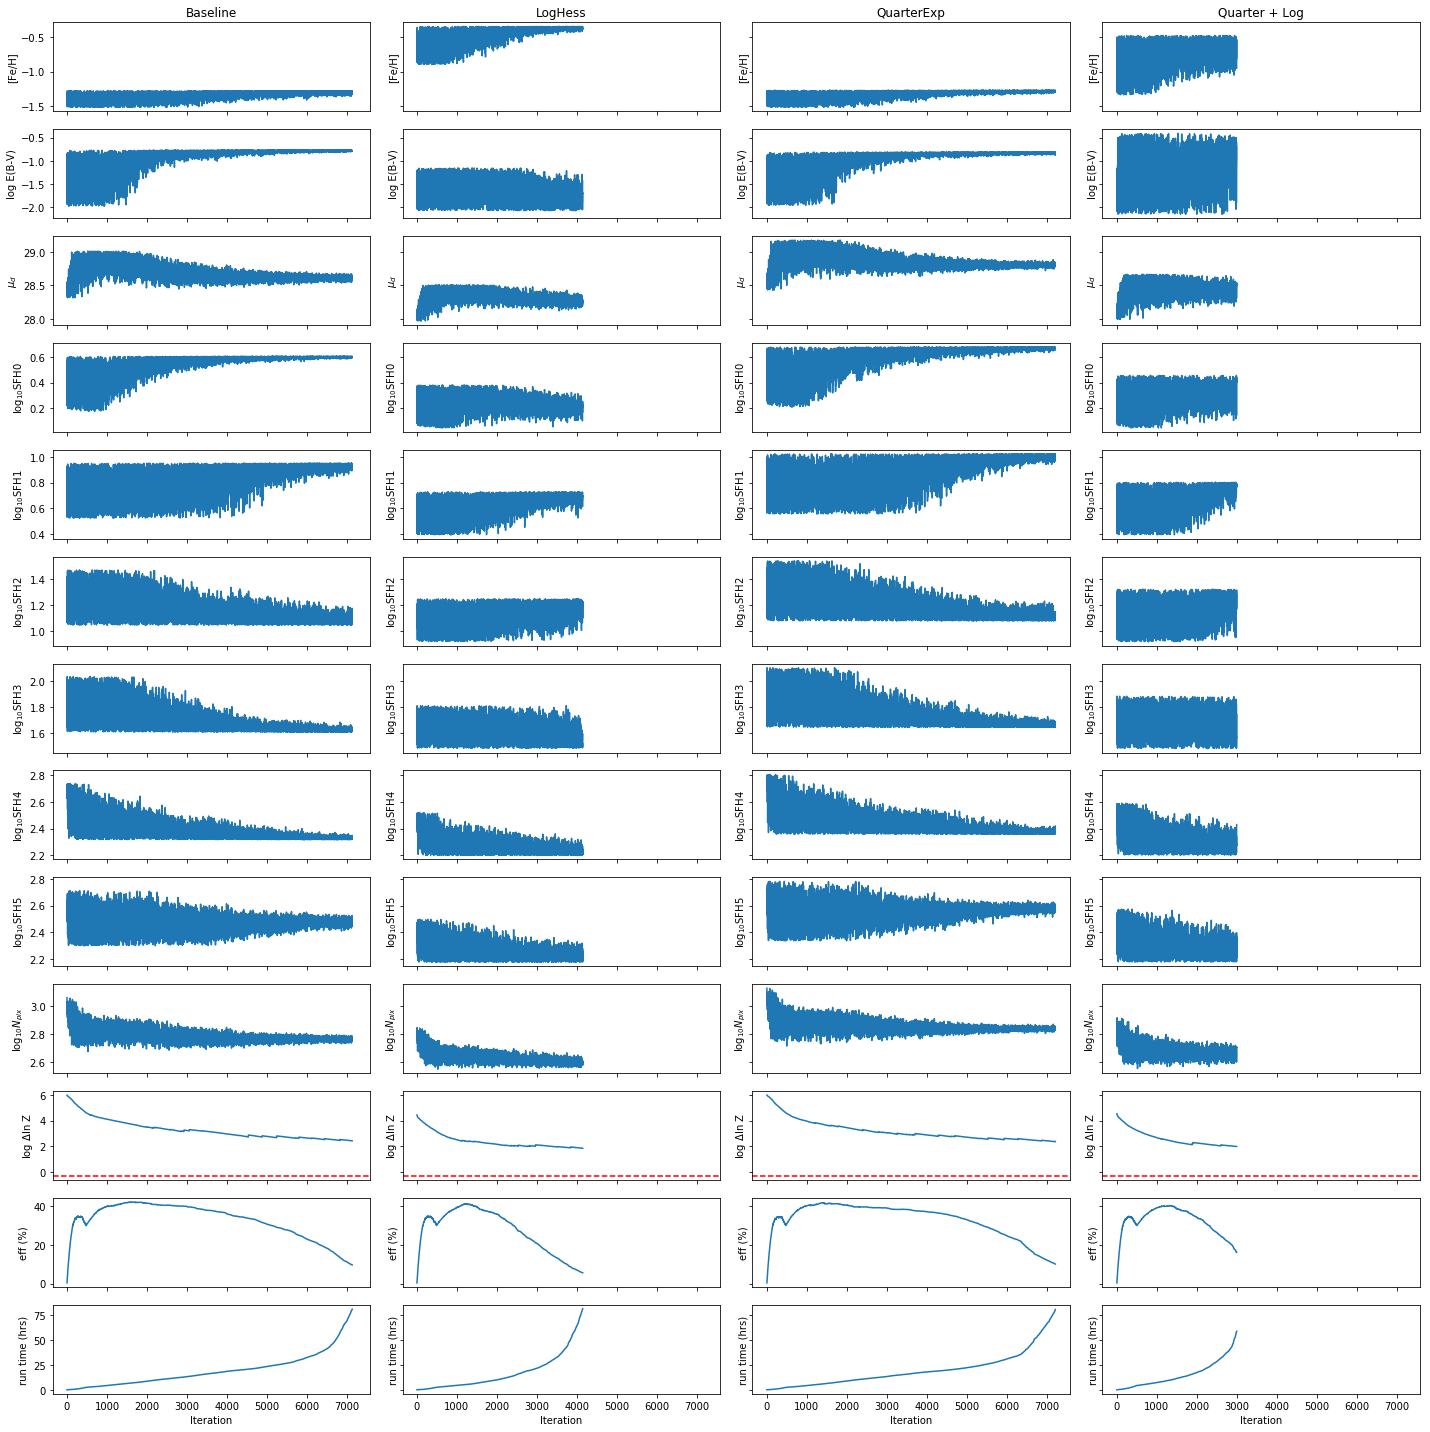

In [8]:
fig, axes = plt.subplots(ncols=4, nrows=13, sharey='row', sharex=True, figsize=(20, 20))
results['base'].plot_chains(axes=axes[:,0]);
results['log'].plot_chains(axes=axes[:,1]);
results['quarter'].plot_chains(axes=axes[:,2]);
results['quarter_log'].plot_chains(axes=axes[:,3]);
# axes[0,0].set_xlim(xmax=5000)
plt.tight_layout()

In [9]:
iso_base = ppy.isochrones.Isochrone_Model(f_base, dm_interp=-1)
iso_low = ppy.isochrones.Isochrone_Model(f_low, dm_interp=-1)

In [10]:
driv_base = ppy.driver.Driver(iso_base, gpu=__GPU_AVAIL)
driv_low = ppy.driver.Driver(iso_low, gpu=__GPU_AVAIL)

In [12]:
pcmds = {}

In [13]:
pcmds['data'] = np.loadtxt('../data/m51_arm2_I-VI-BV.dat', unpack=True)

In [14]:
n_data = int(np.sqrt(pcmds['data'].shape[1])) * 4

In [15]:
bins = [np.arange(23, 30, 0.1), np.arange(-2, 3, 0.1), np.arange(-2, 3, 0.1)]

In [16]:
sky_base = np.array([84., 41., 54.])
sky_low = sky_base / 4.

In [17]:
results['log'].df[results['log'].params].tail()

,logfeh_mean,logdust_med,dmod,logSFH0,logSFH1,logSFH2,logSFH3,logSFH4,logSFH5,logNpix
4124,-0.35644,-1.8132,28.204,0.20664,0.70116,1.1421,1.5358,2.2084,2.2168,2.581119
4125,-0.34161,-1.8392,28.204,0.13016,0.71860,1.1194,1.5575,2.2350,2.1810,2.579029
4126,-0.36009,-1.8984,28.218,0.15962,0.67817,1.0852,1.4959,2.2147,2.2692,2.601533
4127,-0.37508,-1.6630,28.275,0.20495,0.67017,1.1880,1.5330,2.2606,2.2026,2.599317
4128,-0.37685,-1.7096,28.240,0.19206,0.71899,1.2209,1.4989,2.2235,2.1989,2.580189


In [39]:
params = ['logfeh_mean', 'logdust_med', 'logNpix', 'tau', 'dmod']

In [40]:
g1 = ppy.galaxy.TauFull(results['base'].get_chains()[params].values[-1])
g2 = ppy.galaxy.TauFull(np.array([0., -1., 3.3, 10., 29.67]))
g3 = ppy.galaxy.TauFull(results['log'].get_chains()[params].values[-1])

In [41]:
%%time
pcmds['g1_base'] = driv_base.simulate(g1, n_data, fixed_seed=True,
                                      shot_noise=True, sky_noise=sky_base, downsample=5)[0]

CPU times: user 6.43 s, sys: 1.94 s, total: 8.37 s
Wall time: 9.05 s


In [42]:
%%time
pcmds['g2_base'] = driv_base.simulate(g2, n_data, fixed_seed=True,
                                      shot_noise=True, sky_noise=sky_base, downsample=5)[0]

CPU times: user 6.45 s, sys: 2.05 s, total: 8.5 s
Wall time: 8.92 s


In [43]:
%%time
pcmds['g3_base'] = driv_base.simulate(g3, n_data, fixed_seed=True,
                                      shot_noise=True, sky_noise=sky_base, downsample=5)[0]

CPU times: user 6.44 s, sys: 1.9 s, total: 8.34 s
Wall time: 8.76 s


In [44]:
%%time
pcmds['g1_low'] = driv_low.simulate(g1, n_data, fixed_seed=True,
                                    shot_noise=True, sky_noise=sky_low, downsample=5)[0]

CPU times: user 6.65 s, sys: 1.99 s, total: 8.64 s
Wall time: 9.22 s


In [45]:
%%time
pcmds['g2_low'] = driv_low.simulate(g2, n_data, fixed_seed=True,
                                    shot_noise=True, sky_noise=sky_low, downsample=5)[0]

CPU times: user 6.86 s, sys: 1.97 s, total: 8.83 s
Wall time: 9.25 s


In [46]:
%%time
pcmds['g3_low'] = driv_low.simulate(g3, n_data, fixed_seed=True,
                                    shot_noise=True, sky_noise=sky_low, downsample=5)[0]

CPU times: user 6.72 s, sys: 1.99 s, total: 8.71 s
Wall time: 9.12 s


In [47]:
def compare(key, lm=2):
    fig, axes = plt.subplots(ncols=3, nrows=2, sharey=True, sharex='row', figsize=(15, 10))
    norm = mpl.colors.LogNorm()
#     norm = None
    kwargs = {'normed':True}
    pcmd_model = pcmds[key]
    pcmd_data = pcmds['data']
    ppy.plotting.plot_pcmd(pcmd_model, bins=bins, axes=axes[:,0], norm=norm, title=key, hist2d_kwargs=kwargs)
    ppy.plotting.plot_pcmd(pcmd_data, bins=bins, axes=axes[:,1], norm=norm, hist2d_kwargs=kwargs)
    ppy.plotting.plot_pcmd_residual(pcmd_model, pcmd_data, bins=bins, axes=axes[:,2], like_mode=lm)
    ppy.plotting.plot_isochrone(iso_base, axes=axes[:,0])
    ppy.plotting.plot_isochrone(iso_base, axes=axes[:,1])
    ppy.plotting.plot_isochrone(iso_base, axes=axes[:,2])
    axes[0,0].set_ylim([28, 23])
    plt.tight_layout()
    plt.colorbar(ax=axes, label=r'$\pm \chi^2$')
    return axes

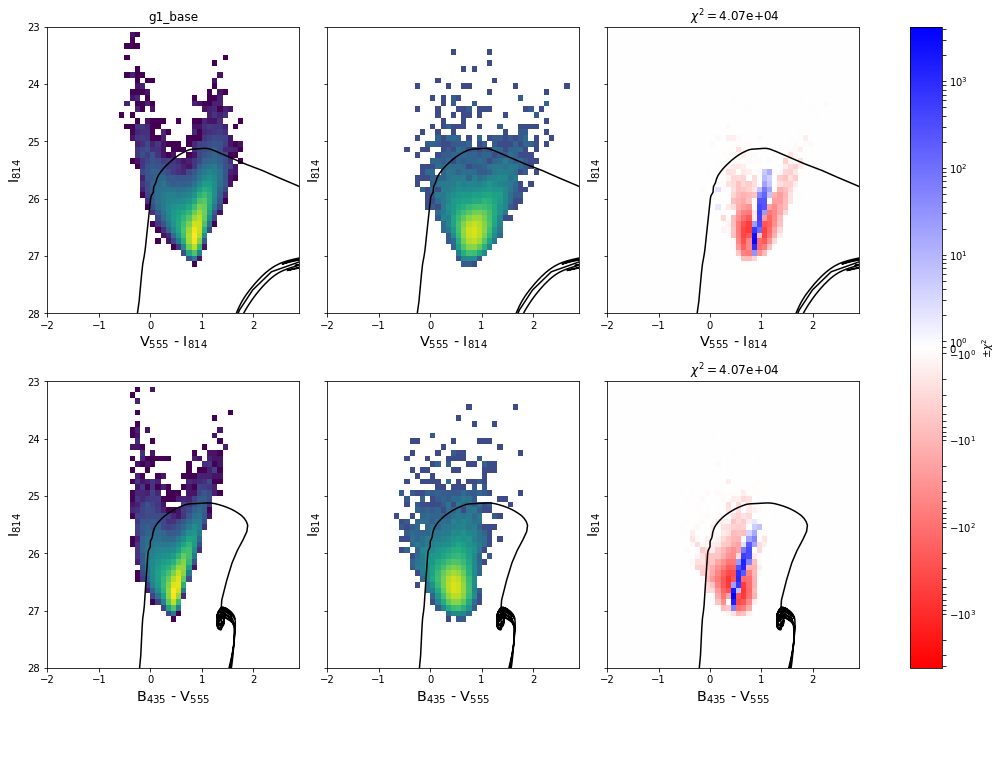

In [48]:
compare('g1_base', lm=2);

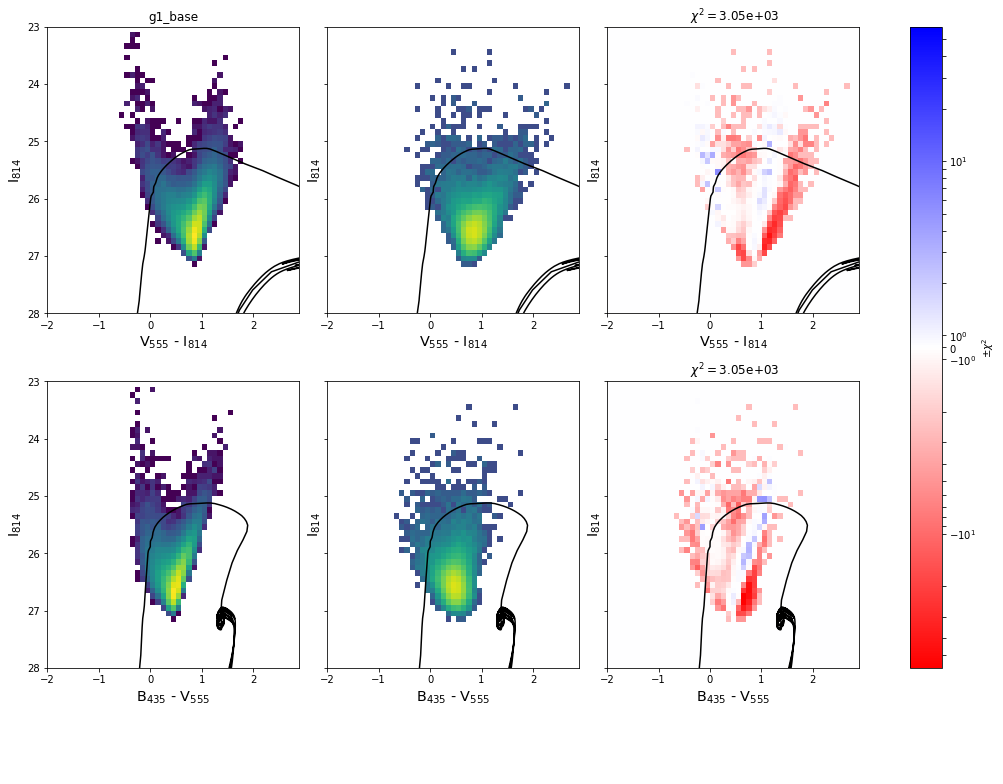

In [49]:
compare('g1_base', lm=1);

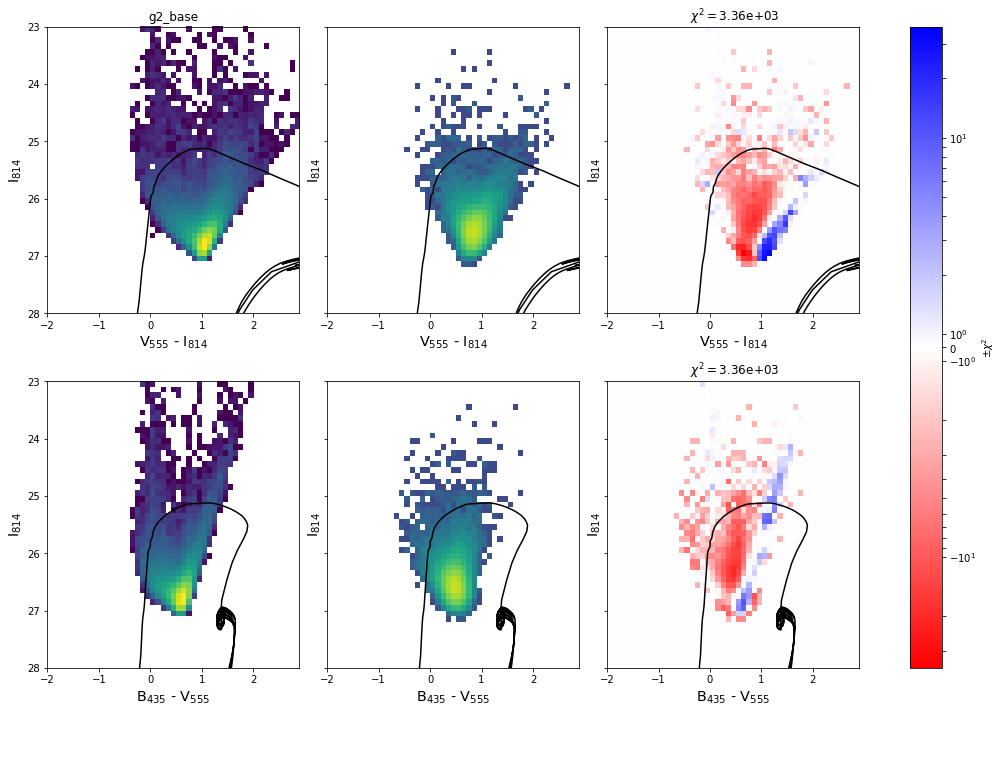

In [50]:
compare('g2_base', lm=1);

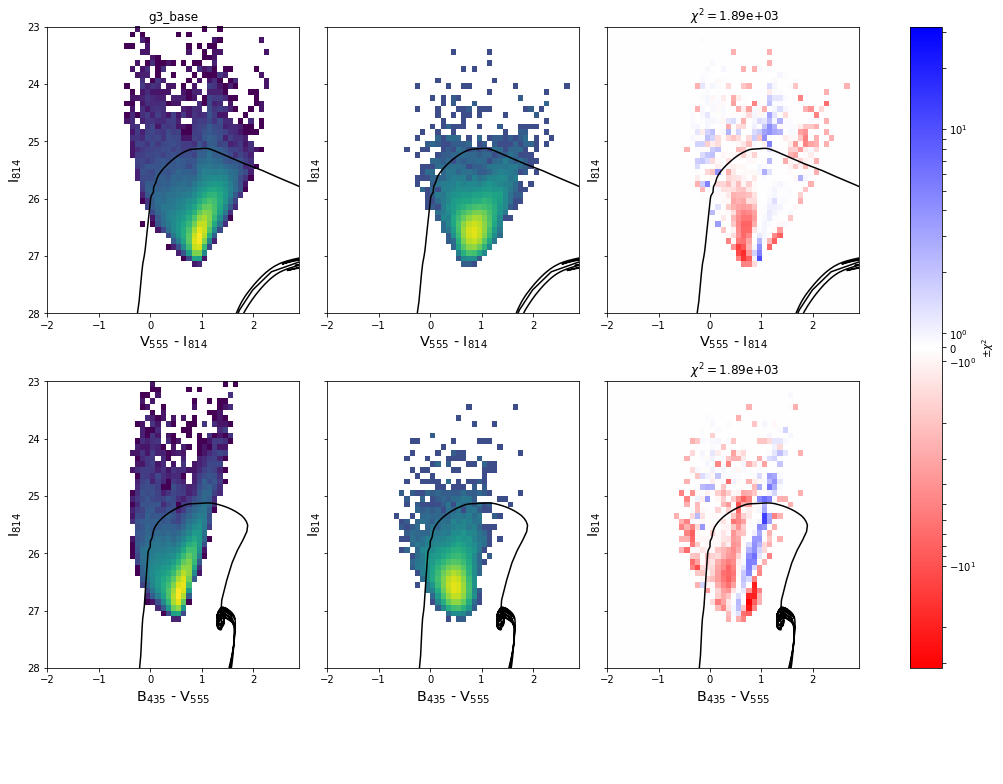

In [51]:
compare('g3_base', lm=1);

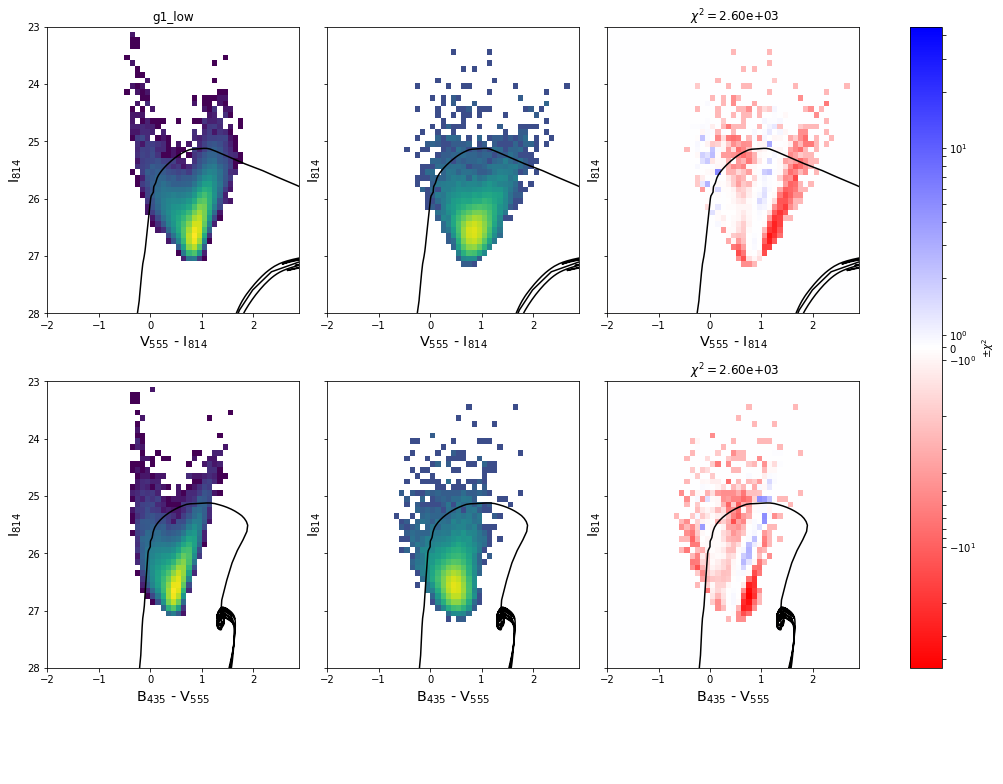

In [52]:
compare('g1_low', lm=1);

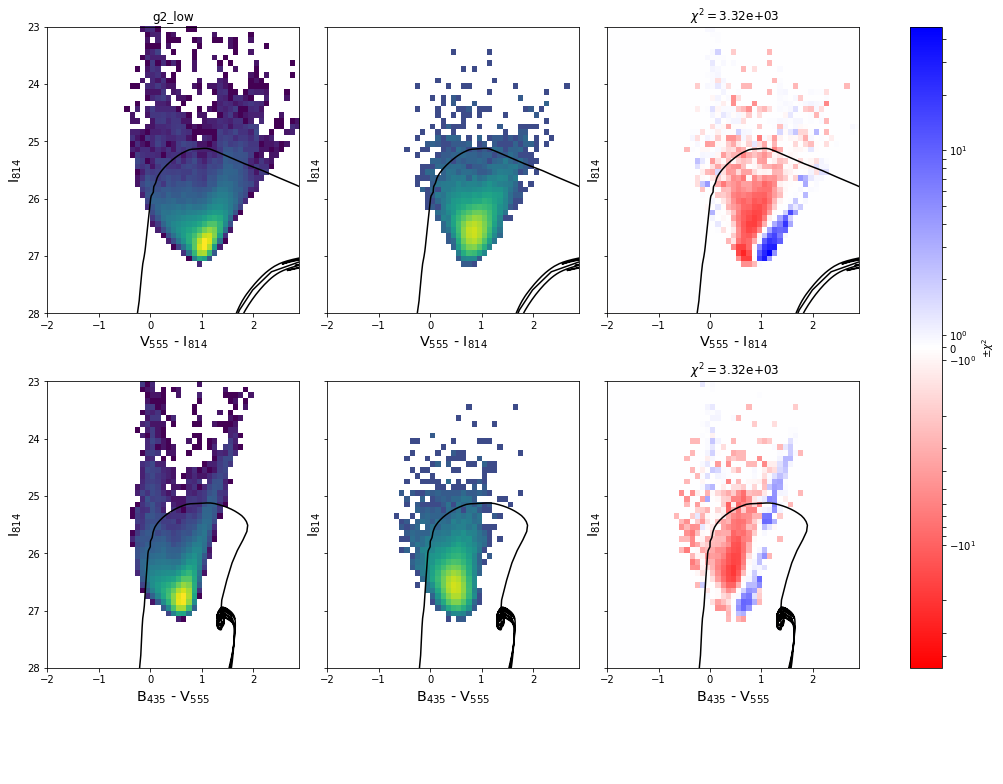

In [53]:
compare('g2_low', lm=1);

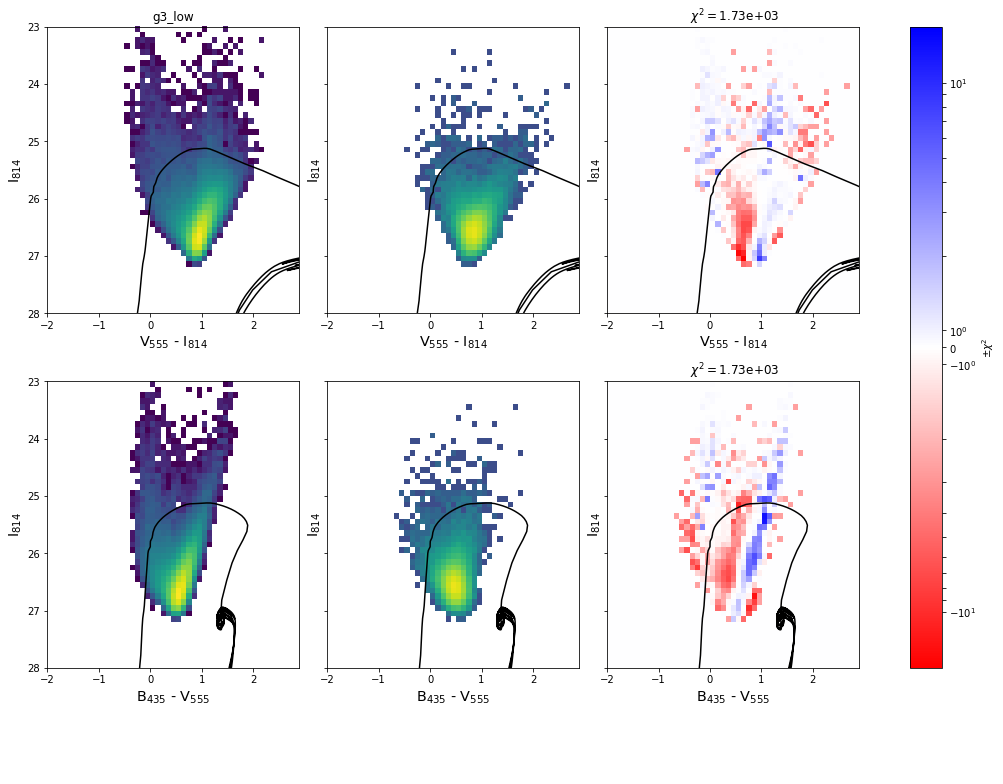

In [54]:
compare('g3_low', lm=1);

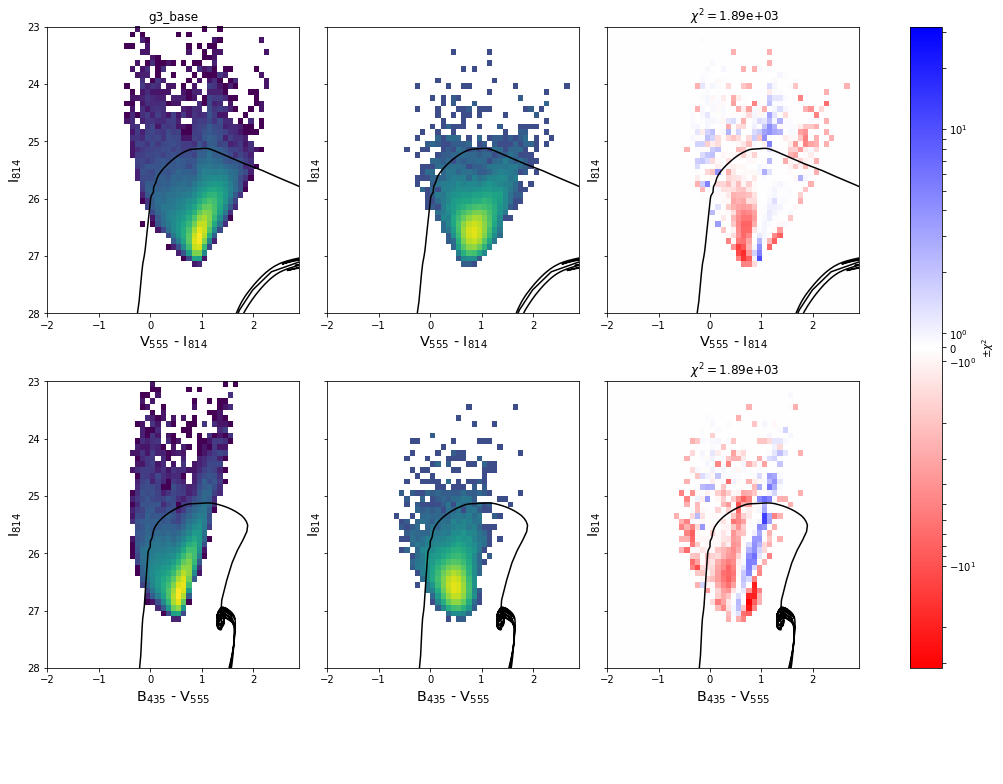

In [51]:
compare('g3_base', lm=1);